In [161]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
%matplotlib inline

In [162]:
#Cargar train data
beer = pd.read_csv("./beer_train.csv",
                               index_col = 0)
print(beer.shape)

# Cargar test data
beertest = pd.read_csv("./beer_test.csv",
                               index_col = 0)
print(beertest.shape)

(24066, 16)
(10314, 15)


# Data explanation

#### __Numeric__:
1. __Size(L)__: Amount brewed for recipe listed
2. __OG__ : Specific gravity of wort before fermentation
3. __FG__ : Specific gravity of wort after fermentation
4. __ABV__: Alcohol By Volume
5. __IBU__: International Bittering Units
6. __Color__: Standard Reference Method. Light to dark. Ex. 40 = black
7. __BoilSize__: Fluid at beginning of boil
8. __BoilTime__: Time wort is boiled
9. __BoilGravity__: Specific gravity of wort before the boil
10. __Efficiency__: Beer mash extraction efficiency - extracting sugars from the grain during mash
11. __MashThickness___: Amount of water per pound of grain
12. __PrimaryTemp__: Temperature at the fermenting stage
13. __PitchRate__: Yeast added to the fermentor per gravity unit - M cells/ml/deg P

#### __Categoric__:
1. __SugarScale__: Scale to determine the concentration of dissolved solids in wort
2. __BrewMethod__: Various techniques for brewing
3. __Style__: Type of brew. VARIABLE TO PREDICT

In [115]:
beer.dtypes

Size(L)          float64
OG               float64
FG               float64
ABV              float64
IBU              float64
Color            float64
BoilSize         float64
BoilTime           int64
BoilGravity      float64
Efficiency       float64
MashThickness    float64
SugarScale        object
BrewMethod        object
PitchRate        float64
PrimaryTemp      float64
Style             object
dtype: object

In [116]:
beer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24066 entries, 0 to 24065
Data columns (total 16 columns):
Size(L)          24066 non-null float64
OG               24066 non-null float64
FG               24066 non-null float64
ABV              24066 non-null float64
IBU              24066 non-null float64
Color            24066 non-null float64
BoilSize         24066 non-null float64
BoilTime         24066 non-null int64
BoilGravity      23130 non-null float64
Efficiency       24066 non-null float64
MashThickness    14200 non-null float64
SugarScale       24066 non-null object
BrewMethod       24066 non-null object
PitchRate        10932 non-null float64
PrimaryTemp      16578 non-null float64
Style            24066 non-null object
dtypes: float64(12), int64(1), object(3)
memory usage: 3.1+ MB


In [117]:
# Percentage of missing values on training data
beer.isnull().sum()/len(beer)*100

Size(L)           0.000000
OG                0.000000
FG                0.000000
ABV               0.000000
IBU               0.000000
Color             0.000000
BoilSize          0.000000
BoilTime          0.000000
BoilGravity       3.889304
Efficiency        0.000000
MashThickness    40.995595
SugarScale        0.000000
BrewMethod        0.000000
PitchRate        54.574919
PrimaryTemp      31.114435
Style             0.000000
dtype: float64

In [118]:
# Percentage of missing values on testing data
beertest.isnull().sum()/len(beertest)*100

Size(L)           0.000000
OG                0.000000
FG                0.000000
ABV               0.000000
IBU               0.000000
Color             0.000000
BoilSize          0.000000
BoilTime          0.000000
BoilGravity       3.218926
Efficiency        0.000000
MashThickness    40.391701
SugarScale        0.000000
BrewMethod        0.000000
PitchRate        54.789606
PrimaryTemp      30.744619
dtype: float64

Style
American Amber Ale      1.046
American Brown Ale      1.046
American IPA            1.051
American Light Lager    1.046
American Pale Ale       1.043
American Stout          1.051
Blonde Ale              1.040
Imperial IPA            1.062
Irish Red Ale           1.043
Saison                  1.045
Witbier                 1.041
Name: BoilGravity, dtype: float64


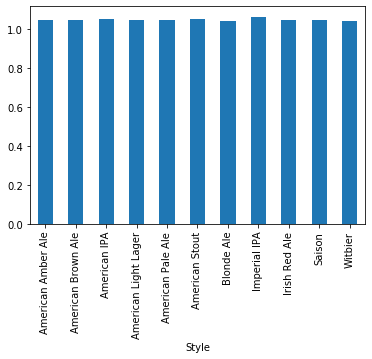

In [119]:
#median of Boil Gravity per style
beer.groupby(['Style']).median()['BoilGravity'].plot(kind='bar')
print(beer.groupby(['Style']).median()['BoilGravity'])

Style
American Amber Ale      1.266163
American Brown Ale      1.228850
American IPA            1.340893
American Light Lager    1.401011
American Pale Ale       1.328633
American Stout          1.334548
Blonde Ale              1.245547
Imperial IPA            1.489458
Irish Red Ale           1.254786
Saison                  1.242850
Witbier                 1.235359
Name: BoilGravity, dtype: float64


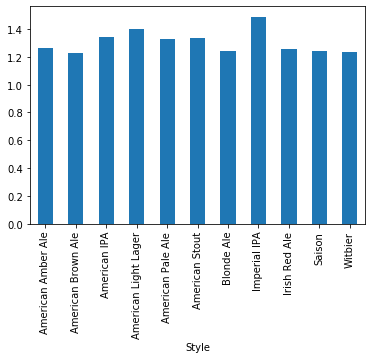

In [120]:
#mean of Boil Gravity per style
beer.groupby(['Style']).mean()['BoilGravity'].plot(kind='bar')
print(beer.groupby(['Style']).mean()['BoilGravity'])

 #  Mods to datasets

 __Replace null values in BoilGravity with mean per Style group  & drop initial BoilGravity__

In [121]:
#Replace null values in TRAIN BoillGravity with mean per Style group  & drop initial BoilGravity
beer2 = beer.copy()

beer2['BoilGravityMod'] = beer['BoilGravity']


beer2['BoilGravityMod'] = beer2.groupby('Style')['BoilGravity'].transform(
    lambda x: x.fillna(x.mean()))

beer2.drop(columns='BoilGravity', inplace=True)




#Replace null values in TEST BoillGravity with mean per Style group  & drop initial BoilGravity
beertest2 = beertest.copy()

beertest2['BoilGravityMod'] = beertest['BoilGravity']


beertest2['BoilGravityMod'] = beer.groupby('Style')['BoilGravity'].transform(
    lambda x: x.fillna(x.mean()))

beertest2.drop(columns='BoilGravity', inplace=True)




In [122]:
beer2['BoilGravityMod'].isnull().sum()/len(beer2['BoilGravityMod'])*100
beertest2['BoilGravityMod'].isnull().sum()/len(beertest2['BoilGravityMod'])*100

0.0

In [123]:
beer2.isnull().sum()/len(beer2)*100
beertest2.isnull().sum()/len(beer2)*100


Size(L)            0.000000
OG                 0.000000
FG                 0.000000
ABV                0.000000
IBU                0.000000
Color              0.000000
BoilSize           0.000000
BoilTime           0.000000
Efficiency         0.000000
MashThickness     17.310729
SugarScale         0.000000
BrewMethod         0.000000
PitchRate         23.481260
PrimaryTemp       13.176265
BoilGravityMod     0.000000
dtype: float64

__Save them as New ones__




In [124]:
beer2.to_csv("beertrain_BoilGravityCleaned.csv")
beertest2.to_csv("beertest_BoilGravityCleaned.csv")


In [125]:

beer_train3 = pd.read_csv("./beertrain_BoilGravityCleaned.csv",index_col = 0)
beer_test3 = pd.read_csv("./beertest_BoilGravityCleaned.csv",index_col = 0)

__Drop columns with too many missing data (+30%)__

In [126]:
beer_train3.drop(columns=['MashThickness','PitchRate','PrimaryTemp'], inplace=True)
beer_test3.drop(columns=['MashThickness','PitchRate','PrimaryTemp'], inplace=True)


__Drop non categorical data__

In [138]:
beer_train4 = beer_train3.copy()
beer_test4 =beer_test3.copy()


beer_train4.head()

,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,Efficiency,SugarScale,BrewMethod,Style,BoilGravityMod
Id,,,,,,,,,,,,,
0,22.71,1.071,1.021,6.51,81.14,6.43,28.39,90,78.0,Specific Gravity,All Grain,American IPA,1.057
1,7.57,1.062,1.016,6.14,138.44,15.28,7.57,60,35.0,Specific Gravity,extract,American IPA,1.062
2,12.00,1.051,1.012,5.17,27.57,14.54,14.00,60,65.0,Specific Gravity,BIAB,Irish Red Ale,1.041
3,15.00,1.051,1.013,5.01,38.53,26.73,19.00,90,65.0,Specific Gravity,All Grain,American Stout,1.040
4,21.77,1.061,1.013,6.25,43.20,4.08,23.66,15,35.0,Specific Gravity,extract,American IPA,1.045


In [139]:
beer_train4.drop(columns=['SugarScale','BrewMethod'], inplace=True)
beer_test4.drop(columns=['SugarScale','BrewMethod'], inplace=True)


 __Create target on train data__

In [140]:
beer_target4 = beer_train4['Style']
beer_train4.drop(columns='Style',inplace=True)



In [141]:
beer_train4.head()

,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,Efficiency,BoilGravityMod
Id,,,,,,,,,,
0,22.71,1.071,1.021,6.51,81.14,6.43,28.39,90,78.0,1.057
1,7.57,1.062,1.016,6.14,138.44,15.28,7.57,60,35.0,1.062
2,12.00,1.051,1.012,5.17,27.57,14.54,14.00,60,65.0,1.041
3,15.00,1.051,1.013,5.01,38.53,26.73,19.00,90,65.0,1.040
4,21.77,1.061,1.013,6.25,43.20,4.08,23.66,15,35.0,1.045


 __Normalization__

In [150]:
scaler = StandardScaler(with_mean=0, with_std=1)
scaler.fit(beer_train4)
X_train_4 = scaler.transform(beer_train4)
X_test_4 = scaler.transform(beer_test4)




 __Decission Tree__

In [153]:
dtree_class = DecisionTreeClassifier()
dtree_class.fit( X_train_4, beer_target4)

y_pred = dtree_class.predict(X_test_4)

y_pred =

array(['American Stout', 'American IPA', 'Irish Red Ale', ...,
       'American Amber Ale', 'Imperial IPA', 'American IPA'], dtype=object)

In [157]:

y_pred = pd.DataFrame(data = y_pred, 
                      index = beer_test4.index,
                      columns = ['Style'])

y_pred.to_csv("DecisionTree_v.1.csv")

 __Random Forest__

In [159]:
rfc = RandomForestClassifier(n_estimators=1000, random_state=101, n_jobs=-1)
rfc.fit(X_train_4, beer_target4)
y_pred_rfc = rfc.predict(X_test_4)



In [160]:
y_pred_rfc = pd.DataFrame(data = y_pred_rfc, 
                      index = beer_test4.index,
                      columns = ['Style'])

y_pred.to_csv("Submission_RandomForest_v.1.csv")

include 